### 모듈 임포트 및 GPU

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 데이터 불러오기 
- ver 1으로 하면 tensor로 변하지 않아서 실행이 안됨

In [4]:
# ver 1
# transform = torch.nn.Sequential(
#     transforms.Resize((224, 224)),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # mean, std 순
# )

# ver 2
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [5]:
# train
trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)

# test
testset = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


### pretrained 모델 불러오기 

In [6]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)

print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [7]:
# Alexnet도 사용해보려고 했지만 VGG16 학습하고 valid하는데 2시간 걸려서 안함
# alexNet = models.alexnet(pretrained=True)
# alexNet.to(device)

# print(alexNet)

In [8]:
# 10개의 class이기 때문에 마지막 out_features를 10으로 바꿔줌
vgg16.classifier[6].out_features = 10
 
# 가중치가 변경되지 않도록 freeze해주어야함 
for param in vgg16.features.parameters():
    param.requires_grad = False

In [9]:
# 10으로 바꿔준 것 확인
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loss 함수 & optimizer 설정

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.01)

### train 함수 작성

In [11]:
def train(model, train_loader):
  model.train()
  train_running_loss = 0.0
  train_running_correct = 0
  
  for i, data in enumerate(train_loader):
    # data[0] -> features
    # data[1] -> labels

    feature = data[0].to(device)
    label = data[1].to(device)

    optimizer.zero_grad()
    
    output = model(feature)

    loss = criterion(output, label)

    train_running_loss += loss.item()
    _, preds = torch.max(output.data, 1)

    train_running_correct += (preds == label).sum().item()
    # if i % 10 == 0:
      # print('i: {}, loss : {}\n _, preds : {}\ntrain_correct : {}'.format(i+1, loss, _, preds, train_running_correct))
    loss.backward()
    optimizer.step()

  # 최종 loss 계산  
  train_loss = train_running_loss / len(train_loader.dataset)
  # 최종 정확도 계산
  train_accuracy = 100 * train_running_correct / len(train_loader.dataset)

  print('Train loss : {:.3f}\nTrain Accuracy : {:.3f}'.format(train_loss, train_accuracy))

  return train_loss, train_accuracy


### validation (test) 함수 작성 

In [12]:
def validation(model, test_loader):
  model.eval()
  val_running_loss = 0.0
  val_running_correct = 0
  
  for i, data in enumerate(test_loader):
    # data[0] -> features
    # data[1] -> labels

    data, label = data[0].to(device), data[1].to(device)

    output = model(data)
    loss = criterion(output, label)

    val_running_loss += loss.item()
    _, preds = torch.max(output.data, 1)

    val_running_correct += (preds == label).sum().item()

  val_loss = val_running_loss / len(test_loader.dataset)
  val_correct = 100 * val_running_correct / len(test_loader.dataset) 

  return val_loss, val_correct

### train & test

In [13]:
train_loss, train_accuracy = [], []
valid_loss, valid_accuracy = [], []

for epoch in range(10):
  print('epoch : {}'.format(epoch))

  train_epoch_loss, train_epoch_accuracy = train(vgg16, train_loader)
  valid_epoch_loss, valid_epoch_accuracy = validation(vgg16, train_loader)

  # train
  train_loss.append(train_epoch_loss)
  train_accuracy.append(train_epoch_accuracy)

  # valid
  valid_loss.append(valid_epoch_loss)
  valid_accuracy.append(valid_epoch_accuracy)

epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train loss : 0.014
Train Accuracy : 70.398
epoch : 1
Train loss : 0.009
Train Accuracy : 80.666
epoch : 2
Train loss : 0.007
Train Accuracy : 83.650
epoch : 3
Train loss : 0.006
Train Accuracy : 86.036
epoch : 4
Train loss : 0.005
Train Accuracy : 87.556
epoch : 5
Train loss : 0.005
Train Accuracy : 89.210
epoch : 6
Train loss : 0.004
Train Accuracy : 90.512
epoch : 7
Train loss : 0.004
Train Accuracy : 91.856
epoch : 8
Train loss : 0.003
Train Accuracy : 92.964
epoch : 9
Train loss : 0.003
Train Accuracy : 94.068


### Accuracy

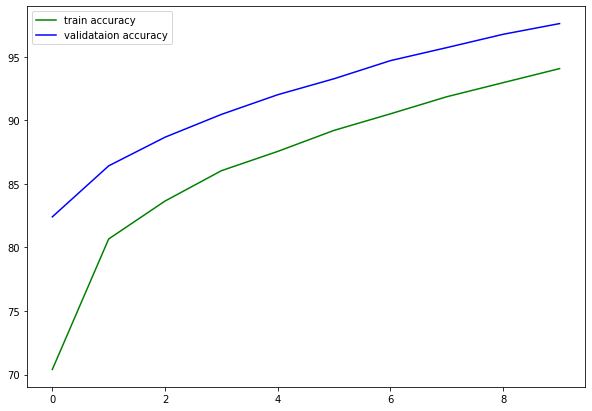

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(valid_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

### Loss

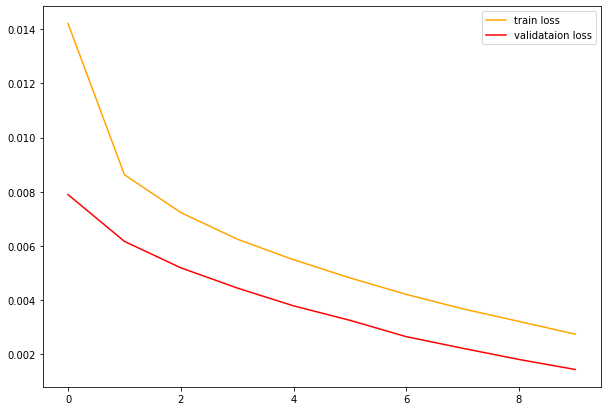

In [15]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()